In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import dotenv
os.chdir(dotenv.find_dotenv().replace('.env', ''))
from src.data_correction import pseudobatch_transform, pseudobatch_transform_pandas, pseudobatch_transform_multiple

## Finite difference functions

In [2]:
def backwards_diff(y:pd.Series, x:pd.Series):
    return y.diff() / x.diff()

In [3]:
def segment_backwards_diff(before_sample:pd.Series, after_sample:pd.Series, time:pd.Series):
    return (before_sample - after_sample.shift()) / (time.diff())

In [4]:
def centered_diff(x, t, i):
    return (x[i+1] - x[i-1]) / (t[i+1] - t[i-1])

In [5]:
def central_diff_with_second_order_estimator(x, h, i):
    '''Estimate the first order direvative using both first and second order taylor approaximation. From https://web.media.mit.edu/~crtaylor/calculator.html'''
    return (1*x[i-2]-8*x[i-1]+0*x[i+0]+8*x[i+1]-1*x[i+2])/(12*1.0*h**1)

## Testing with inhibited data set

In [6]:
dat = pd.read_csv(os.path.join("~/projects/fermentation_simulator/simulated_data", "product_inhibition.csv"))
dat.columns

Index(['sample_volume', 'p', 'timestamp', 'm_Glucose', 'm_Biomass',
       'm_Product', 'm_CO2', 'v_Volume', 'v_Feed_accum', 'c_Glucose',
       'c_Biomass', 'c_Product', 'c_CO2', 'c_Volume', 'c_Feed', 'mu_true'],
      dtype='object')

In [7]:
# Useful variables
concentration_columns = ['c_Biomass', 'c_Glucose', 'c_Product']

biomass_yields = {
    'Biomass': 1,
    'Glucose': -1.85,
    'Product': 0.822,

}

concentration_in_feed_dict = {
    'Biomass': 0,
    'Glucose' :100, 
    'Product':0
}

First, we need to calculate the true values for the cultivation parameters, $q_c$, and $r_c$ the volumetric and specific rates.

$$
q_c = X(t) * \mu(t) * Y_{xc} \\
r_c = \mu(t) * Y_{xc}
$$

In [8]:
def volumetric_rate(mu, yield_coef, biomass_conc):
    return mu * yield_coef * biomass_conc

def specific_rate(mu, yield_coef):
    return mu * yield_coef

In [9]:
## Calculate the true rates 
for colname in concentration_columns:
    _ , species = colname.split('_')
    dat[f'{species}_volumetric_rate_true'] = volumetric_rate(
        dat['mu_true'], 
        biomass_yields[species], 
        dat['c_Biomass']
    )

    dat[f'specific_{species}_rate_true'] = specific_rate(
        dat['mu_true'], 
        biomass_yields[species]
    )



The data contains two values for the sampling time points one is the before sample and on is the after sample.

In [10]:
meas = (dat
    .query("not(sample_volume.isna())")
    .filter([
        'p', 
        'timestamp', 
        'sample_volume', 
        'v_Volume', 
        'v_Feed_accum', 
        'mu_true', 
        'Glucose_volumetric_rate_true', 
        'Product_volumetric_rate_true', 
        'Biomass_volumetric_rate_true',
        'specific_Glucose_rate_true', 
        'specific_Product_rate_true', 
        'specific_Biomass_rate_true', 
        'c_Biomass', 
        'c_Glucose', 
        'c_Product'
    ])
    .copy()
)
meas['type'] = ["After sampling" if x else "Before sampling" for x in meas.timestamp.duplicated()]
meas = meas.query("type == 'Before sampling'") # for simplicity we remove the after sample time points
meas.head()

,p,timestamp,sample_volume,v_Volume,v_Feed_accum,mu_true,Glucose_volumetric_rate_true,Product_volumetric_rate_true,Biomass_volumetric_rate_true,specific_Glucose_rate_true,specific_Product_rate_true,specific_Biomass_rate_true,c_Biomass,c_Glucose,c_Product,type
167,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",10.000000,100.0,1015.906036,15.906036,0.098350,-0.239268,0.106313,0.129334,-0.181947,0.080843,0.098350,1.315046,0.117208,0.676000,Before sampling
245,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",14.545455,100.0,928.960902,28.960902,0.097930,-0.367071,0.163098,0.198416,-0.181170,0.080498,0.097930,2.026109,0.171224,1.265827,Before sampling
322,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",19.090909,100.0,847.314262,47.314262,0.096131,-0.548379,0.243658,0.296421,-0.177842,0.079019,0.096131,3.083525,0.296168,2.143140,Before sampling
400,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",23.636364,100.0,772.816654,72.816654,0.090714,-0.766665,0.340648,0.414414,-0.167821,0.074567,0.090714,4.568350,0.651151,3.375809,Before sampling
478,"[0.15, 0.3, 1.85, 0.8215102466751038, 0.045193...",28.181818,100.0,707.795685,107.795685,0.079949,-0.948139,0.421281,0.512507,-0.147906,0.065718,0.079949,6.410392,1.735493,4.907704,Before sampling


In [11]:
def mass_before_sample(conc:pd.Series, volume_before:pd.Series)->pd.Series: 
    return conc * volume_before

def mass_after_sample(conc:pd.Series, volume_before:pd.Series, sample_volume:pd.Series)->pd.Series:
    return conc * (volume_before - sample_volume)

In [12]:

for colname in concentration_columns:
    _, species = colname.split('_')
    meas[f'm_{species}_before'] = mass_before_sample(meas[colname], volume_before = meas.v_Volume)
    meas[f'm_{species}_after'] = mass_after_sample(meas[colname], volume_before = meas.v_Volume, sample_volume = meas.sample_volume)
meas

concentration_in_feed = np.array([0, 100, 0]).reshape(1,-1)

meas[['c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_Product_pseudo']] = pseudobatch_transform_multiple(
    meas[concentration_columns].to_numpy(),
    meas.v_Volume.to_numpy(),
    meas.v_Feed_accum.diff().fillna(0).to_numpy(),
    concentration_in_feed,
    meas.sample_volume.to_numpy()
)

### Visualising the the raw data

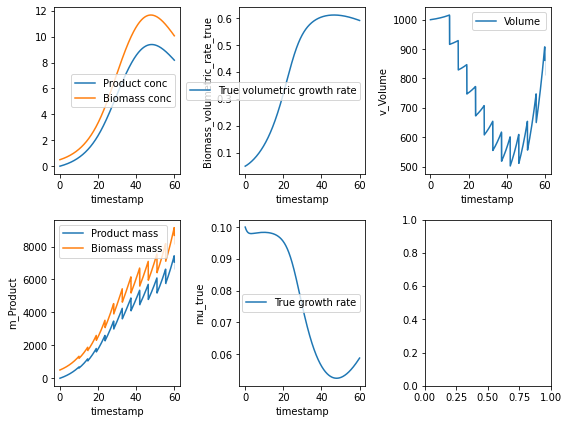

In [13]:
fig, axes = plt.subplots(2,3)

sns.lineplot(x=dat['timestamp'], y = dat[f'Biomass_volumetric_rate_true'], ax=axes[0,1], label = 'True volumetric growth rate')
sns.lineplot(x=dat['timestamp'], y = dat['m_Product']/dat['v_Volume'], ax=axes[0,0], label = 'Product conc')
sns.lineplot(x=dat['timestamp'], y = dat['m_Biomass']/dat['v_Volume'], ax=axes[0,0], label = 'Biomass conc')
sns.lineplot(x=dat['timestamp'], y = dat['m_Product'], ax=axes[1,0], label = 'Product mass')
sns.lineplot(x=dat['timestamp'], y = dat['m_Biomass'], ax=axes[1,0], label = 'Biomass mass')
sns.lineplot(x = dat['timestamp'], y = dat['mu_true'], ax=axes[1,1], label='True growth rate')
sns.lineplot(x = dat['timestamp'], y = dat['v_Volume'], ax=axes[0,2], label='Volume')
fig.set_size_inches((8,6))
fig.tight_layout()
fig.savefig("reports/figures/fed-batch-prod-inhib-overview.png", dpi = 300)

### Calculating finite differences

In [14]:
## Estimating growth rates
meas['raw_Biomass_est'] = segment_backwards_diff(
    meas['m_Biomass_before'], 
    meas['m_Biomass_after'], 
    meas['timestamp']
)

meas['pseudo_Biomass_est_backwards'] = backwards_diff(
    meas['c_Biomass_pseudo'], 
    meas['timestamp']
)

h = meas.timestamp.diff().iloc[1] # calculates step sizes, assuming equidistant samples
dXdt = np.array([np.nan, np.nan]) # The second order requires two point on each side of the center point
for i in range(2,len(meas.timestamp)-2):
    res = central_diff_with_second_order_estimator(
        meas.c_Biomass_pseudo.to_numpy(),
        h,
        i
    )
    dXdt = np.append(dXdt, [res])
dXdt = np.append(dXdt, [np.nan, np.nan])
meas['pseudo_Biomass_est_2nd_order'] = dXdt

This shows that the backwards finite difference is a quite poor estimate of the growth rate.

The above is estimates the growth rate as the centered finite difference of the pseudo biomass $\frac{dX}{dt} * V$. In the pseudo batch domain the volume is constant with regards to time and thus is just one. The units of this differential quotient is $\frac{gX /L}{h}$, usually we seek the specific growth rate and we can obtain that by dividing by the pseudo biomass concentration. 
$$\hat\mu(t) : \frac{gX/L}{h} * \frac{1}{gX/L} = \frac{1}{h}$$

In [15]:
meas['raw_specific_Biomass_est'] = meas['raw_Biomass_est'] / meas['m_Biomass_before']
meas['pseudo_specific_Biomass_est_backwards'] = meas['pseudo_Biomass_est_backwards'] / meas['c_Biomass_pseudo']
meas['pseudo_specific_Biomass_est_2nd_order'] = meas['pseudo_Biomass_est_2nd_order'] / meas['c_Biomass_pseudo']

<AxesSubplot:xlabel='timestamp', ylabel='c_Biomass_pseudo'>

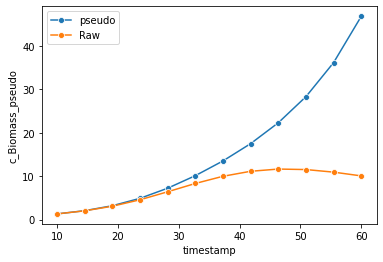

In [16]:
sns.lineplot(data = meas, x = 'timestamp', y = 'c_Biomass_pseudo', label='pseudo', marker='o')
sns.lineplot(data = meas, x = 'timestamp', y = 'c_Biomass', label = 'Raw', marker = 'o')

In [17]:
## calculate the error
meas['raw_specific_Biomass_est_relerr'] = (meas['mu_true'] - meas['raw_specific_Biomass_est']) / meas['mu_true']
meas['pseudo_specific_Biomass_est_2nd_order_relerr'] = (meas['mu_true'] - meas['pseudo_specific_Biomass_est_2nd_order']) / meas['mu_true']
meas['pseudo_specific_Biomass_est_backwards_relerr'] = (meas['mu_true'] - meas['pseudo_specific_Biomass_est_backwards']) / meas['mu_true']

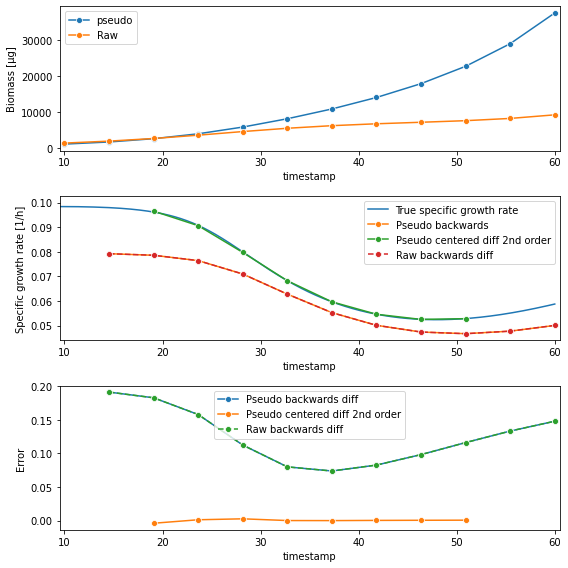

In [18]:
fig, axes = plt.subplots(3, 1)

# Biomass
sns.lineplot(x = meas.timestamp, y = meas.c_Biomass_pseudo * 800, label='pseudo', ax = axes[0], marker='o') # calculated pseudo mass 
sns.lineplot(data = meas, x = 'timestamp', y = 'm_Biomass_before', label = 'Raw', ax = axes[0], marker='o')

# Specific growth rate
sns.lineplot(data = dat, x = 'timestamp', y = 'mu_true', label = 'True specific growth rate', ax = axes[1])
sns.lineplot(data = meas, x = 'timestamp', y = 'pseudo_specific_Biomass_est_backwards', label= 'Pseudo backwards', ax = axes[1], marker='o')
sns.lineplot(data = meas, x = 'timestamp', y = 'pseudo_specific_Biomass_est_2nd_order', label= 'Pseudo centered diff 2nd order', ax = axes[1], marker='o')
sns.lineplot(data = meas, x = 'timestamp', y = 'raw_specific_Biomass_est', label= 'Raw backwards diff', ax = axes[1], marker='o', linestyle='--')

# Error
sns.lineplot(data = meas, x = 'timestamp', y = 'pseudo_specific_Biomass_est_backwards_relerr', label= 'Pseudo backwards diff', ax = axes[2], marker='o')
sns.lineplot(data = meas, x = 'timestamp', y = 'pseudo_specific_Biomass_est_2nd_order_relerr', label= 'Pseudo centered diff 2nd order', ax = axes[2], marker='o')
sns.lineplot(x = meas['timestamp'], y = meas['raw_specific_Biomass_est_relerr'], label= 'Raw backwards diff', ax = axes[2], marker='o', linestyle='--')

axes[1].set_ylabel("Specific growth rate [1/h]")
axes[0].set_ylabel("Biomass [µg]")
axes[2].set_ylabel("Error")

for ax in axes:
    ax.set_xlim(9.5, 60.5)
fig.set_size_inches((8,8))
fig.tight_layout()
fig.savefig("reports/figures/finite_difference.png", dpi=300)

Probably it will be more convincing with an example with a few more samples, measurement noise and higher order estimations of the first derivative>

## Estimation of finite differences with measurement errors in the data

In [19]:
def add_noise(x, relerr):
    return np.random.normal(x, x * relerr)

In [20]:
from functools import partial
np.random.seed(9854543) # 9042985
add_noise_closure = partial(add_noise, relerr = 0.05)
meas_noisy = meas.drop(columns=concentration_columns)

for colname in concentration_columns:
    _, species = colname.split('_')
    meas_noisy[colname] = meas[colname].apply(add_noise_closure)
    meas_noisy[f'm_{species}_before'] = mass_before_sample(meas_noisy[colname], volume_before = meas_noisy.v_Volume)
    meas_noisy[f'm_{species}_after'] = mass_after_sample(meas_noisy[colname], volume_before = meas_noisy.v_Volume, sample_volume = meas_noisy.sample_volume)
meas_noisy


concentration_in_feed = np.array([0, 100, 0]).reshape(1,-1)

meas_noisy[['c_Biomass_pseudo', 'c_Glucose_pseudo', 'c_Product_pseudo']] = pseudobatch_transform_multiple(
    meas_noisy[concentration_columns].to_numpy(),
    meas_noisy.v_Volume.to_numpy(),
    meas_noisy.v_Feed_accum.to_numpy(),
    concentration_in_feed,
    meas_noisy.sample_volume.to_numpy()
)


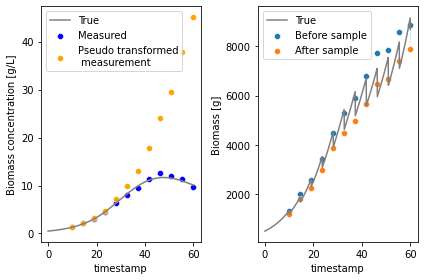

In [21]:
fig, axes = plt.subplots(1,2)
sns.lineplot(x=dat['timestamp'], y = dat['c_Biomass'], label = 'True', ax = axes[0], color = 'grey')
sns.scatterplot(x = meas_noisy['timestamp'], y = meas_noisy['c_Biomass'], label = 'Measured', ax = axes[0], color='blue')
sns.scatterplot(x = meas_noisy['timestamp'], y = meas_noisy['c_Biomass_pseudo'], label = 'Pseudo transformed\n measurement', ax = axes[0], color='orange')
axes[0].set_ylabel("Biomass concentration [g/L]")

sns.lineplot(x=dat['timestamp'], y = dat['m_Biomass'], label = 'True', ax = axes[1], color='grey')
sns.scatterplot(x = meas_noisy['timestamp'], y = meas_noisy['m_Biomass_before'], label = 'Before sample', ax = axes[1])
sns.scatterplot(x = meas_noisy['timestamp'], y = meas_noisy['m_Biomass_after'], label = 'After sample', ax = axes[1])
axes[1].set_ylabel("Biomass [g]")
fig.set_size_inches(6,4)
fig.tight_layout()
fig.savefig("reports/figures/fed-batch-prod-inhib-noisy-biomass-conc.png", dpi = 300)

In [22]:
## Estimatingf {species} differential quotients
for colname in concentration_columns:
    _ , species = colname.split('_')
    meas_noisy[f'raw_{species}_mass_diff_est'] = segment_backwards_diff(
        meas_noisy[f'm_{species}_before'], 
        meas_noisy[f'm_{species}_after'], 
        meas_noisy['timestamp']
    )

    meas_noisy[f'pseudo_{species}_conc_diff_est_backwards'] = backwards_diff(
        meas_noisy[f'c_{species}_pseudo'], 
        meas_noisy['timestamp']
    )

    h = meas_noisy.timestamp.diff().iloc[1] # calculates step sizes, assuming equidistant samples
    dXdt = np.array([np.nan, np.nan]) # The second order requires two point on each side of the center point
    for i in range(2,len(meas_noisy.timestamp)-2):
        res = central_diff_with_second_order_estimator(
            meas_noisy[f'c_{species}_pseudo'].to_numpy(),
            h,
            i
        )
        dXdt = np.append(dXdt, [res])
    dXdt = np.append(dXdt, [np.nan, np.nan])
    meas_noisy[f'pseudo_{species}_conc_diff_est_2nd_order'] = dXdt

The rate estimate based on the raw data is based on mass', thus estimating $\frac{dcV}{dt}$ the change in mass over time. For the pseudo batch the finite difference is between pseudo concentrations, thus estimating $\frac{dc^{pseudo}}{dt}$, with the units $\frac{g}{L * h}$, i.e. the volumetric rate. We will now convert the rate estimates from the raw data to volumetric rates. Using equation 9.49 in Bioreaction Engineering Principles

<img src="../reports/derivation_of_volumetric_rate_eq.jpg" alt="derivation" width="400"/>


In [23]:
## Calculate volumetric rates for for raw data estimates
def volumetric_rate_from_finite_diff(dmdt, V, concentration_in_feed, dilution_factor):
    '''dmdt is the finite difference of the mass. V is the volume'''
    return (dmdt / V) - (concentration_in_feed) * dilution_factor
    
for colname in concentration_columns:
    _ , species = colname.split('_')
    meas_noisy[f'raw_{species}_volumetric_rate_est'] = volumetric_rate_from_finite_diff(
        meas_noisy[f'raw_{species}_mass_diff_est'], 
        meas_noisy['v_Volume'], 
        concentration_in_feed_dict[species], 
        (dat['v_Feed_accum'].diff() / dat['v_Volume'])
    )


The specific growth rate estimates are calculated through the following equation:
$$
r_c = \frac{q_c}{X(t)}
$$
The volumetric rates for the raw data was estimated above. While for the pseudo batch transformed data, this models a batch culture, thus the volumetric rates are just the concentration difference quotient.

$$
\frac{dc^{pseudo}}{dt} = q_c
$$

In [24]:
## Calculate specific rates
for colname in concentration_columns:
    _ , species = colname.split('_')
    meas_noisy[f'raw_specific_{species}_rate_est'] = meas_noisy[f'raw_{species}_volumetric_rate_est'] / meas_noisy['c_Biomass']
    meas_noisy[f'pseudo_specific_{species}_rate_est_backwards'] = meas_noisy[f'pseudo_{species}_conc_diff_est_backwards'] / meas_noisy['c_Biomass_pseudo']
    meas_noisy[f'pseudo_specific_{species}_rate_est_2nd_order'] = meas_noisy[f'pseudo_{species}_conc_diff_est_2nd_order'] / meas_noisy['c_Biomass_pseudo']

The true rates are calculated through the following equation:
$$
r_y = \mu * Y_{xy}
$$
Where $r_y$ is the true rate of species $y$, $\mu$ is the specific growth rate and $Y_{xy}$ is the biomass yield of species $y$.

In [25]:
## calculate the error
def relative_error(true, estimate):
    return (true - estimate) / true

## For specific rates
for colname in concentration_columns:
    _ , species = colname.split('_')
    meas_noisy[f'raw_specific_{species}_rate_est_relerr'] = relative_error(meas_noisy[f'specific_{species}_rate_true'], meas_noisy[f'raw_specific_{species}_rate_est'])
    meas_noisy[f'pseudo_specific_{species}_rate_est_2nd_order_relerr'] = relative_error(meas_noisy[f'specific_{species}_rate_true'], meas_noisy[f'pseudo_specific_{species}_rate_est_backwards'])
    meas_noisy[f'pseudo_specific_{species}_rate_est_backwards_relerr'] = relative_error(meas_noisy[f'specific_{species}_rate_true'], meas_noisy[f'pseudo_specific_{species}_rate_est_2nd_order'])

## For volumetric rate
for colname in concentration_columns:
    _ , species = colname.split('_')
    meas_noisy[f'raw_{species}_volumetric_rate_est_relerr'] = relative_error(meas[f'{species}_volumetric_rate_true'], meas_noisy[f'raw_{species}_volumetric_rate_est'])
    meas_noisy[f'pseudo_{species}_volumetric_rate_est_2nd_order_relerr'] = relative_error(meas[f'{species}_volumetric_rate_true'], meas_noisy[f'pseudo_{species}_conc_diff_est_2nd_order'])
    meas_noisy[f'pseudo_{species}_volumetric_rate_est_backwards_relerr'] = relative_error(meas[f'{species}_volumetric_rate_true'], meas_noisy[f'pseudo_{species}_conc_diff_est_backwards'])


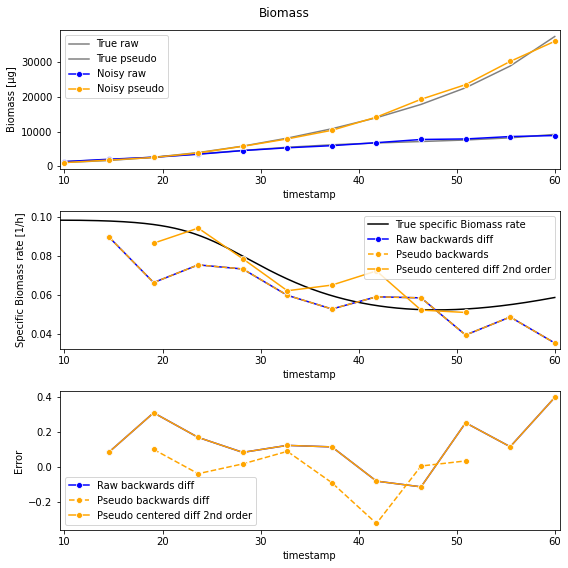

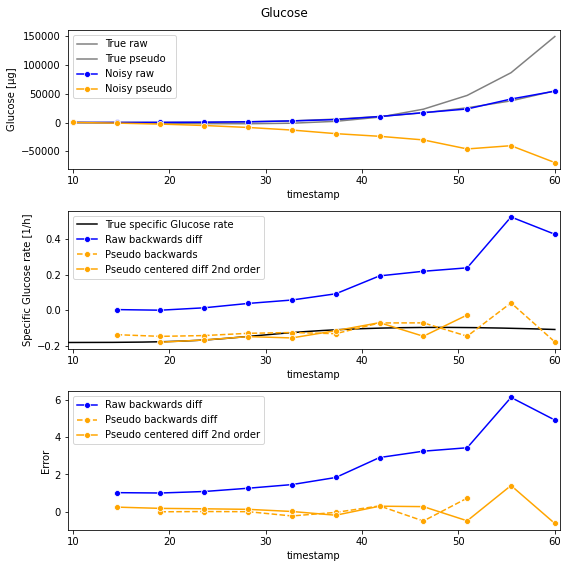

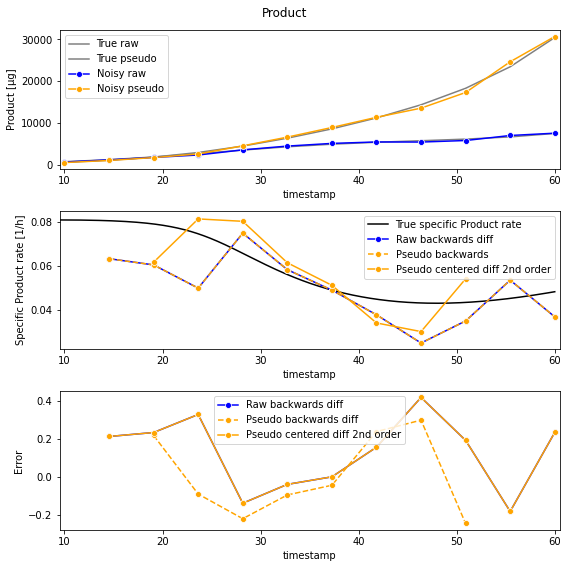

In [26]:

for colname in concentration_columns:
    fig, axes = plt.subplots(3, 1)

    _ , species = colname.split('_')
    # {species}
    sns.lineplot(data = meas, x = 'timestamp', y = f'm_{species}_before', label = 'True raw', ax = axes[0], color='grey')
    sns.lineplot(x = meas.timestamp, y = meas[f'c_{species}_pseudo'] * 800, label='True pseudo', ax = axes[0], color='grey') # calculated pseudo mass 
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'm_{species}_before', label = 'Noisy raw', ax = axes[0], marker='o', color='blue')
    sns.lineplot(x = meas_noisy.timestamp, y = meas_noisy[f'c_{species}_pseudo'] * 800, label='Noisy pseudo', ax = axes[0], marker='o', color = 'orange') # calculated pseudo mass 

    # Specific growth rate
    sns.lineplot(x = dat['timestamp'], y = dat[f'specific_{species}_rate_true'], label = f'True specific {species} rate', ax = axes[1], color = 'black')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'raw_specific_{species}_rate_est', label= 'Raw backwards diff', ax = axes[1], marker='o', color = 'blue')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_specific_{species}_rate_est_backwards', label= 'Pseudo backwards', ax = axes[1], marker='o', color='orange', linestyle='--')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_specific_{species}_rate_est_2nd_order', label= 'Pseudo centered diff 2nd order', ax = axes[1], marker='o', color='orange')

    # Error
    sns.lineplot(x = meas_noisy['timestamp'], y = meas_noisy[f'raw_specific_{species}_rate_est_relerr'], label= 'Raw backwards diff', ax = axes[2], marker='o', color='blue')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_specific_{species}_rate_est_backwards_relerr', label= 'Pseudo backwards diff', ax = axes[2], marker='o', linestyle='--', color='orange')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_specific_{species}_rate_est_2nd_order_relerr', label= 'Pseudo centered diff 2nd order', ax = axes[2], marker='o', color='orange')

    axes[1].set_ylabel(f"Specific {species} rate [1/h]")
    axes[0].set_ylabel(f"{species} [µg]")
    axes[2].set_ylabel("Error")

    for ax in np.ravel(axes):
        ax.set_xlim(9.5, 60.5)
    fig.set_size_inches((8,8))
    fig.suptitle(species)
    fig.tight_layout()
    fig.savefig(f"reports/figures/finite_difference_noisy_{species}.png", dpi=300)

Now, I will summaries the error of the rate estimates. To make the comparison more fair I will use only the the points were we obtain estimates through all methods.

In [27]:
(meas_noisy
    .dropna(axis=0)
    .filter(['pseudo_specific_Biomass_rate_est_backwards_relerr', 'pseudo_specific_Biomass_rate_est_2nd_order_relerr', 'raw_specific_Biomass_rate_est_relerr'])
    .describe()
)

,pseudo_specific_Biomass_rate_est_backwards_relerr,pseudo_specific_Biomass_rate_est_2nd_order_relerr,raw_specific_Biomass_rate_est_relerr
count,8.000000,8.000000,8.000000
mean,-0.026639,0.106373,0.106373
std,0.135545,0.147059,0.147059
min,-0.324504,-0.114757,-0.114757
25%,-0.052457,0.041297,0.041297
50%,0.010501,0.118173,0.118173
75%,0.047184,0.189042,0.189042
max,0.099419,0.309084,0.309084


Surprisingly, the standard deviation of the 2nd order finite difference is approximately the same or a bit larger than the backwards diffs. Thus, the second order method does not appear to smoothen the estimate of the rates, though it still centers the estimate around the true value, where as the backwards difference appears to be offset from the true value. I hypothesis that this off set comes from the division with the $X_i$. This is biomass at the end of the interval, thus for growing cultures it will always over estimate the amount of cells that produced the biomass during the interval.

When we calculate the specific growth rate from the we divide by the measured biomass. The biomass measurement has measurement error, that will affect the estimate of the specific growth rate. Currently, this biomass is just used as is, thus there is no attempt to smoothen the values.

## Volumetric growth rates

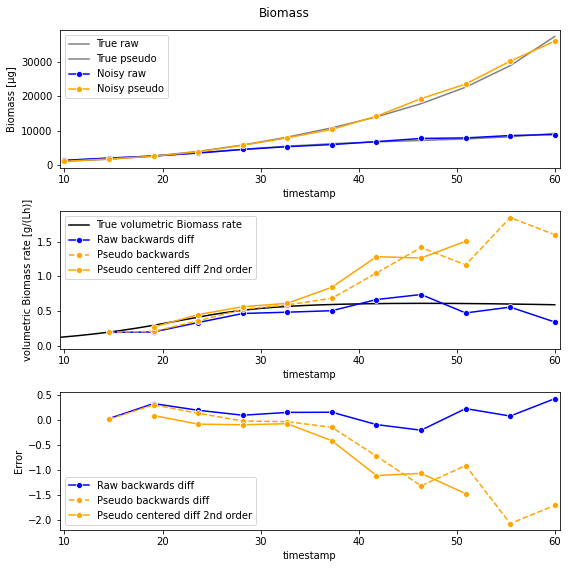

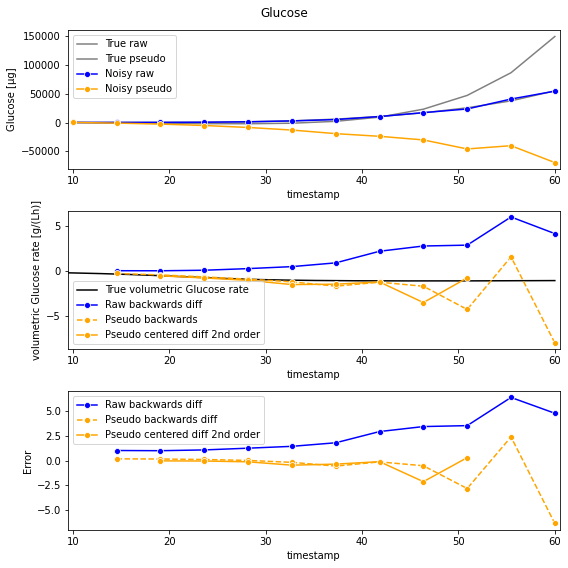

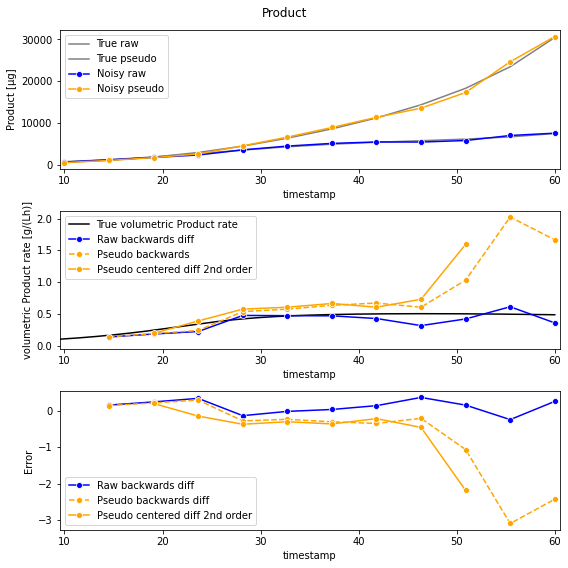

In [28]:

for colname in concentration_columns:
    fig, axes = plt.subplots(3, 1)

    _ , species = colname.split('_')
    # {species}
    sns.lineplot(data = meas, x = 'timestamp', y = f'm_{species}_before', label = 'True raw', ax = axes[0], color='grey')
    sns.lineplot(x = meas.timestamp, y = meas[f'c_{species}_pseudo'] * 800, label='True pseudo', ax = axes[0], color='grey') # calculated pseudo mass 
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'm_{species}_before', label = 'Noisy raw', ax = axes[0], marker='o', color='blue')
    sns.lineplot(x = meas_noisy.timestamp, y = meas_noisy[f'c_{species}_pseudo'] * 800, label='Noisy pseudo', ax = axes[0], marker='o', color = 'orange') # calculated pseudo mass 

    # Specific growth rate
    sns.lineplot(x = dat['timestamp'], y = dat[f'{species}_volumetric_rate_true'], label = f'True volumetric {species} rate', ax = axes[1], color = 'black')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'raw_{species}_volumetric_rate_est', label= 'Raw backwards diff', ax = axes[1], marker='o', color = 'blue')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_{species}_conc_diff_est_backwards', label= 'Pseudo backwards', ax = axes[1], marker='o', color='orange', linestyle='--')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_{species}_conc_diff_est_2nd_order', label= 'Pseudo centered diff 2nd order', ax = axes[1], marker='o', color='orange')

    # Error
    sns.lineplot(x = meas_noisy['timestamp'], y = meas_noisy[f'raw_{species}_volumetric_rate_est_relerr'], label= 'Raw backwards diff', ax = axes[2], marker='o', color='blue')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_{species}_volumetric_rate_est_backwards_relerr', label= 'Pseudo backwards diff', ax = axes[2], marker='o', linestyle='--', color='orange')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_{species}_volumetric_rate_est_2nd_order_relerr', label= 'Pseudo centered diff 2nd order', ax = axes[2], marker='o', color='orange')

    axes[1].set_ylabel(f"volumetric {species} rate [g/(Lh)]")
    axes[0].set_ylabel(f"{species} [µg]")
    axes[2].set_ylabel("Error")

    for ax in np.ravel(axes):
        ax.set_xlim(9.5, 60.5)
    fig.set_size_inches((8,8))
    fig.suptitle(species)
    fig.tight_layout()
    fig.savefig(f"reports/figures/finite_difference_noisy_volumetric_{species}_overview.png", dpi=300)

So far the backwards diff of the raw data appears to be most accurate with the volumetric growth rate, but I suspect that it is due to the way we calculate the volumetric rates for the pseudo batch.

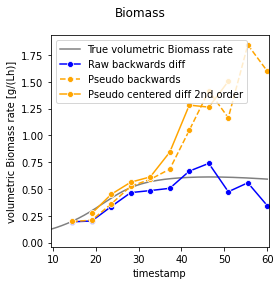

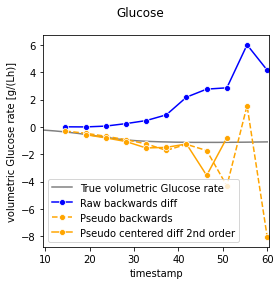

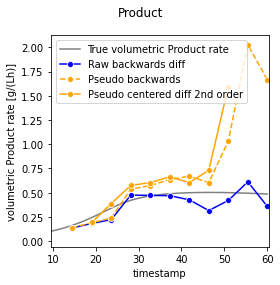

In [29]:

for colname in concentration_columns:
    fig, ax = plt.subplots(1, 1)

    _ , species = colname.split('_')
    # Specific growth rate
    sns.lineplot(x = dat['timestamp'], y = dat[f'{species}_volumetric_rate_true'], label = f'True volumetric {species} rate', ax = ax, color = 'grey')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'raw_{species}_volumetric_rate_est', label= 'Raw backwards diff', ax = ax, marker='o', color = 'blue')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_{species}_conc_diff_est_backwards', label= 'Pseudo backwards', ax = ax, marker='o', color='orange', linestyle='--')
    sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'pseudo_{species}_conc_diff_est_2nd_order', label= 'Pseudo centered diff 2nd order', ax = ax, marker='o', color='orange')

    ax.set_ylabel(f"volumetric {species} rate [g/(Lh)]")
    ax.set_xlim(9.5, 60.5)
    fig.set_size_inches((4,4))
    fig.suptitle(species)
    fig.tight_layout()

    fig.savefig(f"reports/figures/finite_difference_noisy_volumetric_{species}.png", dpi=300)

## Testing reverse pseudo batch transformation

In [31]:
from src.data_correction import accumulated_diluation_factor
from typing import Union

def reverse_pseudobatch_transform(pseudo_concentration: np.array, reactor_volume:np.array, accumulated_feed: np.array, concentration_in_feed: Union[np.array, float], sample_volume:np.array) -> np.array:
    '''Does the pseudo batch transformation for one species. The function returns a np.array of the pseudo batch transformed measurements.

    measured_concetration: a np.array with the measured concentration of the species that should be transformed, e.g. biomass or compound.
    reactor_volume: a np.array of bioreator volume. The volume MUST be the volumes just BEFORE sampling.
    accumulated_feed:.
    concentration_in_feed: a np.array OR a float of the concentration of the species in the feed, for biomass and products this is 0
    sample_volume: a np.array of the sample volumes at given time points. The array should contain 0 at timepoints where no samples was taken
    '''
    after_sample_reactor_volume = reactor_volume - sample_volume
    adf = accumulated_diluation_factor(after_sample_reactor_volume, sample_volume)

    # calculate the feed in interval. prepand the first value to the array makes
    # sure that the first value is 0
    feed_in_interval = np.diff(accumulated_feed, prepend=accumulated_feed[0])

    return (pseudo_concentration + np.cumsum(adf * feed_in_interval * concentration_in_feed / reactor_volume)) / adf

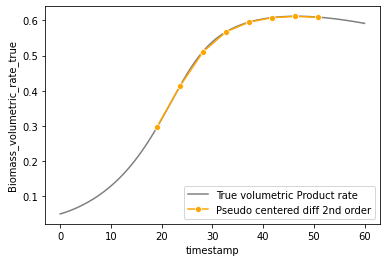

In [32]:
test = reverse_pseudobatch_transform(
    meas['pseudo_Biomass_est_2nd_order'].to_numpy(),
    meas.v_Volume.to_numpy(),
    meas.v_Feed_accum.diff().fillna(0).to_numpy(),
    0,
    meas.sample_volume.to_numpy()
)

sns.lineplot(x = dat['timestamp'], y = dat[f'Biomass_volumetric_rate_true'], label = f'True volumetric {species} rate', color = 'grey')
sns.lineplot(x = meas_noisy['timestamp'], y = test, label= 'Pseudo centered diff 2nd order', marker='o', color='orange')
plt.savefig('reports/figures/finite_difference_reverse_transformed_volumetric_rate.png')

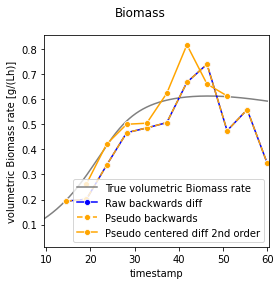

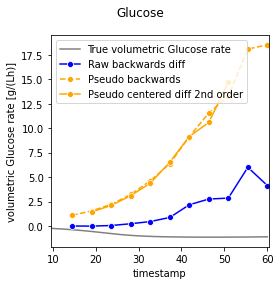

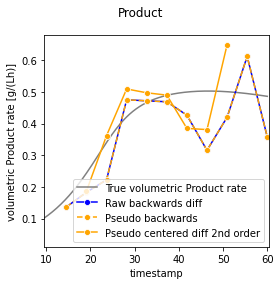

In [33]:
for colname in concentration_columns:
  fig, ax = plt.subplots(1, 1)

  _ , species = colname.split('_')
  meas_noisy[f'rt_pseudo_{species}_conc_diff_est_backwards'] = reverse_pseudobatch_transform(
    meas_noisy[f'pseudo_{species}_conc_diff_est_backwards'], 
    meas.v_Volume.to_numpy(),
    meas.v_Feed_accum.diff().fillna(0).to_numpy(),
    concentration_in_feed_dict[species],
    meas.sample_volume.to_numpy()
  )

  meas_noisy[f'rt_pseudo_{species}_conc_diff_est_2nd_order'] = reverse_pseudobatch_transform(
    meas_noisy[f'pseudo_{species}_conc_diff_est_2nd_order'], 
    meas.v_Volume.to_numpy(),
    meas.v_Feed_accum.diff().fillna(0).to_numpy(),
    concentration_in_feed_dict[species],
    meas.sample_volume.to_numpy()
  )

  meas_noisy[f'rt_pseudo_{species}_conc_diff_est_backwards_relerror'] = relative_error(dat[f'{species}_volumetric_rate_true'], meas_noisy[f'rt_pseudo_{species}_conc_diff_est_backwards'])
  meas_noisy[f'rt_pseudo_{species}_conc_diff_est_2nd_order_relerror'] = relative_error(dat[f'{species}_volumetric_rate_true'], meas_noisy[f'rt_pseudo_{species}_conc_diff_est_2nd_order'])

  # Specific growth rate
  sns.lineplot(x = dat['timestamp'], y = dat[f'{species}_volumetric_rate_true'], label = f'True volumetric {species} rate', ax = ax, color = 'grey')
  sns.lineplot(data = meas_noisy, x = 'timestamp', y = f'raw_{species}_volumetric_rate_est', label= 'Raw backwards diff', ax = ax, marker='o', color = 'blue')
  sns.lineplot(x = meas_noisy['timestamp'], y = meas_noisy[f'rt_pseudo_{species}_conc_diff_est_backwards'], label= 'Pseudo backwards', ax = ax, marker='o', color='orange', linestyle='--')
  sns.lineplot(x = meas_noisy['timestamp'], y = meas_noisy[f'rt_pseudo_{species}_conc_diff_est_2nd_order'], label= 'Pseudo centered diff 2nd order', ax = ax, marker='o', color='orange')

  ax.set_ylabel(f"volumetric {species} rate [g/(Lh)]")
  ax.set_xlim(9.5, 60.5)
  fig.set_size_inches((4,4))
  fig.suptitle(species)
  fig.tight_layout()
  


Investigate the variance of the relative error to see if the methods smoothens out the data.

In [34]:
meas_noisy.filter(regex = r"rt_pseudo_.*_conc_diff_est_.*_relerror").agg(['mean', 'std']).T

,mean,std
rt_pseudo_Biomass_conc_diff_est_backwards_relerror,0.121243,0.176871
rt_pseudo_Biomass_conc_diff_est_2nd_order_relerror,-0.028812,0.144057
rt_pseudo_Glucose_conc_diff_est_backwards_relerror,8.776910,5.310367
rt_pseudo_Glucose_conc_diff_est_2nd_order_relerror,7.162090,3.730526
rt_pseudo_Product_conc_diff_est_backwards_relerror,0.124210,0.192109
rt_pseudo_Product_conc_diff_est_2nd_order_relerror,0.008737,0.208910


Looking at the standard deviation on the relative error of the volumetric growth rate, there seems to be no benefit from increasing the finite difference order. For biomass the the std for the 2nd order method is slightly smaller, but for the product the backwards method is slightly smaller. Thus, it appears that similar to the specific rates the measurement noise is not decreased using higher order differences.

### Overall plots

<AxesSubplot:xlabel='timestamp', ylabel='specific_Biomass_rate_true'>

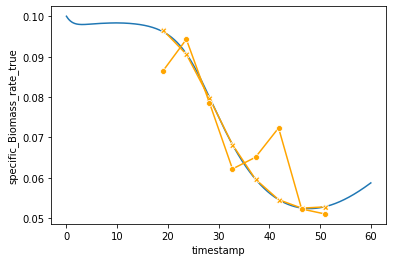

In [35]:
## true rate, estimate based on true values, estiamte based on noisy values
## legend draft
## linestyle+color ~ pseudo (--) vs raw
## marker ~ exact measurements vs noisy
## OR make two plots one raw and pseudo or exact and noisy

species = 'Biomass'
fig, ax = plt.subplots(1, 1)

sns.lineplot(data=dat, x = 'timestamp', y=f'specific_{species}_rate_true', ax = ax)
sns.lineplot(data=meas, x = 'timestamp', y=f'pseudo_specific_{species}_est_2nd_order', ax = ax, marker='X', color='orange')
sns.lineplot(data=meas_noisy, x = 'timestamp', y=f'pseudo_specific_{species}_rate_est_2nd_order', ax = ax, marker='o', color='orange')





In [36]:
meas.specific_Biomass_rate_true

167     0.098350
245     0.097930
322     0.096131
400     0.090714
478     0.079949
555     0.068244
633     0.059673
711     0.054637
788     0.052553
866     0.052863
944     0.055091
1021    0.058768
Name: specific_Biomass_rate_true, dtype: float64